### Training Parameterized Quantum Circuits

In [164]:
#Training Parameterized Quantum Circuits
from qiskit.circuit.library import RealAmplitudes

In [165]:
anstaz = RealAmplitudes(num_qubits=2, reps=1, insert_barriers=True).decompose()

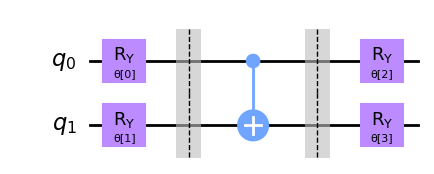

In [166]:
anstaz.draw('mpl')

#### __Finite Difference Gradient__

In [167]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

In [168]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(anstaz)
pauli_expectation = PauliExpectation().convert(expectation)

In [169]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler

import numpy as np

quantum_instance = QuantumInstance(
    Aer.get_backend(
        'qasm_simulator',
        shots = 8192, 
        seed_simulator = 2718,
        seed_transpiler = 2718
    )
)

sampler = CircuitSampler(quantum_instance)

In [170]:
def evaluate_expectation(theta):
    value_dict = dict(zip(anstaz.parameters, theta))
    result = sampler.convert(pauli_expectation, params=value_dict).eval()
    return np.real(result)

In [171]:
point = np.random.random(anstaz.num_parameters)
INDEX = 2

In [172]:
EPS = 0.2

e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

In [173]:
final_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(final_difference)

-0.21484375000000028


Doing what's above using `Gradient`

In [174]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=anstaz.parameters[INDEX])
print(grad)

value_dict = dict(zip(anstaz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐ ░       ░ ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├─░───■───░─┤ Ry(θ[2] + 0.2) ├
         ├──────────┤ ░ ┌─┴─┐ ░ └──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├─░─┤ X ├─░────┤ Ry(θ[3]) ├───
         └──────────┘ ░ └───┘ ░    └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐ ░       ░ ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├─░───■───░─┤ Ry(θ[2] - 0.2) ├
         ├──────────┤ ░ ┌─┴─┐ ░ └──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├─░─┤ X ├─░────┤ Ry(θ[3]) ├───
         └──────────┘ ░ └───┘ ░    └──────────┘   
    )
  ])
])


-0.15136718749999978

#### __Analytic Gradient__

Using `Gradient`

In [178]:
shift = Gradient() #parameter shifter by default
gradient = shift.convert(expectation, params=anstaz.parameters[INDEX])
sampler.convert(gradient, value_dict).eval().real

-0.1220703125